In [ ]:
import os
import torch
from src.utilities.polar_traversal import (scale_mesh, flip_mesh)
from torchvision.transforms import (ToPILImage, GaussianBlur)
from src.augment.geoaug import GeoAugment

from src.config import get_parser

torch.Size([1, 4030, 3]) torch.Size([1, 8000, 3])
torch.Size([1, 4030, 3]) torch.Size([1, 8000, 3])
torch.Size([1, 1, 512, 512])


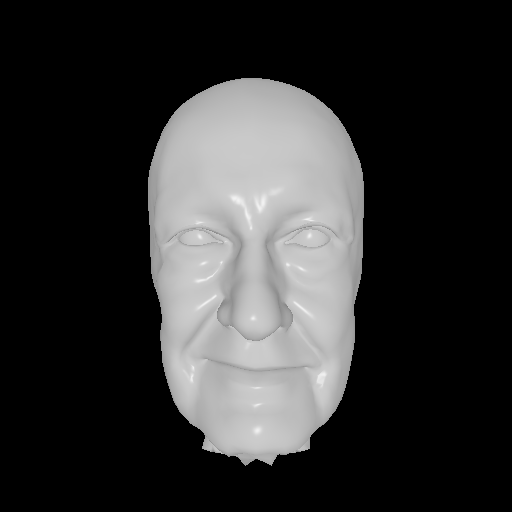

In [21]:
# pyright: reportMissingImports=false
import os
import torch 
import torch.nn.functional as F 

from pytorch3d.structures import Pointclouds
import pytorch3d.transforms as T3
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    look_at_view_transform,
    PointLights,
    DirectionalLights,
    RasterizationSettings,
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesVertex,
)
from pytorch3d.renderer.blending import BlendParams
from src.utilities.util import make_faces
from src.utilities.util import  grid_to_list

class MeshFaceRenderer(torch.nn.Module):
    def __init__(self, opt):    
        super(MeshFaceRenderer, self).__init__()
        self.opt = opt
        self.max_brightness = opt.raster_max_brightness        
        size = opt.fast_outline_size
        self.register_buffer('faces',  torch.tensor(make_faces(size, size))[None])
        self.renderer = None
    
    def setup(self, device):                    
        R, T = look_at_view_transform(
            self.opt.viewpoint_distance, 
            self.opt.viewpoint_elevation, 
            self.opt.viewpoint_azimuth, 
            device=device)
        cameras = FoVPerspectiveCameras(
            device=device, R=R, T=T)
        raster_settings = RasterizationSettings(
            image_size= self.opt.fast_image_size, 
            blur_radius=self.opt.raster_blur_radius, 
            faces_per_pixel=self.opt.raster_faces_per_pixel,
        )
        rasterizer= MeshRasterizer(
            cameras=cameras, 
            raster_settings=raster_settings
        )        
        lights = PointLights(device=device, 
                             location=[self.opt.lights_location])
        lights = DirectionalLights(device=device, 
              direction=[self.opt.lights_direction],
              specular_color=[self.opt.specular_color])
        shader = SoftPhongShader(
            device=device, 
            cameras=cameras,
            lights=lights,
            blend_params=BlendParams(
              self.opt.blend_params_sigma,
              self.opt.blend_params_gamma,
              self.opt.blend_params_background_color,
            ),
        )        
        self.renderer = MeshRenderer(
            rasterizer=rasterizer,
            shader=shader,
        )
    
    def __call__(self, vertices, faces, device):                
        colors = torch.ones_like(vertices)
        if  self.renderer is None:
            self.setup(device)        
        textures = TexturesVertex(verts_features=colors)

        mesh = Meshes(verts=vertices, faces=faces, textures=textures)
        r_images = self.renderer(mesh)        
        r_images = r_images.permute(0, 3, 1, 2).contiguous()
        r_images = r_images[:, :3, :, :].mean(dim=1, keepdim=True)        
        return r_images
    
config = get_parser().parse_args(args=[])   

config.fast_image_size = 512
config.raster_faces_per_pixel = 4
config.lights_direction = [0.0, 0.0, 3.0]

    
config.specular_color = [0.15, 0.15, 0.15]

from math import pi

config.viewpoint_distance = 2.5
config.viewpoint_elevation =  0.0#, pi/2, -pi /2]
config.viewpoint_azimuth = 0.0#, 0.0, 0.0]

R = MeshFaceRenderer(config)
device = torch.device('cuda')

file = './data/stan-lee-face.stl'
mesh  = flip_mesh(scale_mesh(file, offset=-0.20))
verts = torch.tensor(mesh.vertices, device=device).float()[None]
faces = torch.tensor(mesh.faces, device=device)[None]
#views_no = len(config.viewpoint_azimuth)
print(verts.shape, faces.shape)

#verts =  verts.expand(views_no, -1, -1)
#faces = faces.expand(views_no, -1, -1)
print(verts.shape, faces.shape)
verts = verts + torch.tensor([0.0, -0.25, 0.0], device=device)
renders =  R(verts, faces, device)
print(renders.shape)
img = ToPILImage()(renders[0])
img

torch.Size([1, 1, 512, 512])


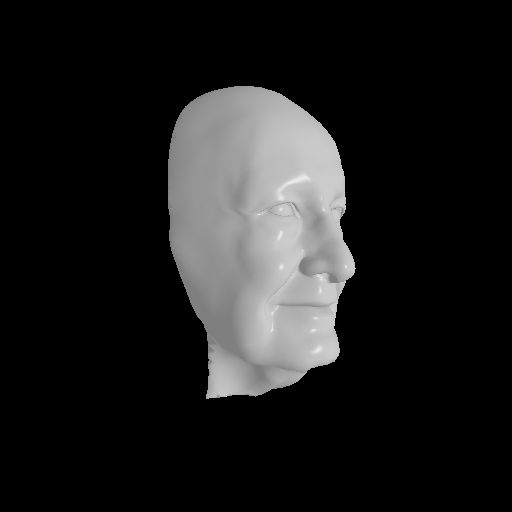

In [22]:
config.viewpoint_distance = 2.5
config.viewpoint_elevation =  0##, -pi /2]
config.viewpoint_azimuth = -45#, 0.0, 0.0]

SR = MeshFaceRenderer(config)
device = torch.device('cuda')

file = './data/stan-lee-face.stl'
mesh  = flip_mesh(scale_mesh(file, offset=-0.20))
verts = torch.tensor(mesh.vertices, device=device).float()[None]
faces = torch.tensor(mesh.faces, device=device)[None]
#views_no = len(config.viewpoint_azimuth)

verts = GeoAugment(verts, config.geoaug_policy)
renders =  SR(verts, faces, device)
print(renders.shape)
img = ToPILImage()(renders[0])
img

torch.Size([1, 1, 512, 512])


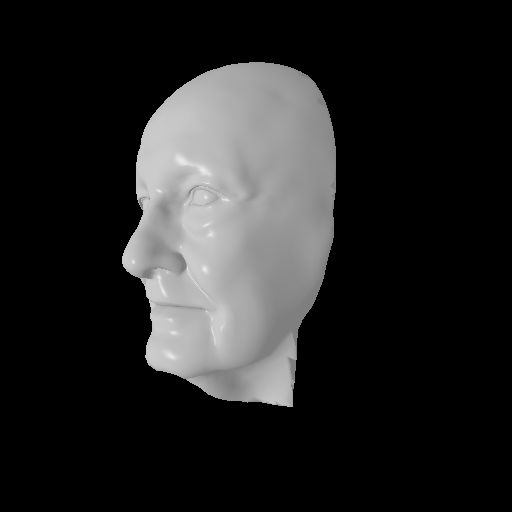

In [23]:
#config.viewpoint_distance = 2.5
#config.viewpoint_elevation =  0##, -pi /2]
config.viewpoint_azimuth = +45#, 0.0, 0.0]

SR = MeshFaceRenderer(config)
device = torch.device('cuda')

file = './data/stan-lee-face.stl'
mesh  = flip_mesh(scale_mesh(file, offset=-0.20))
verts = torch.tensor(mesh.vertices, device=device).float()[None]
faces = torch.tensor(mesh.faces, device=device)[None]
#views_no = len(config.viewpoint_azimuth)

verts = GeoAugment(verts, config.geoaug_policy)
renders =  SR(verts, faces, device)
print(renders.shape)
img = ToPILImage()(renders[0])
img

torch.Size([1, 1, 512, 512])


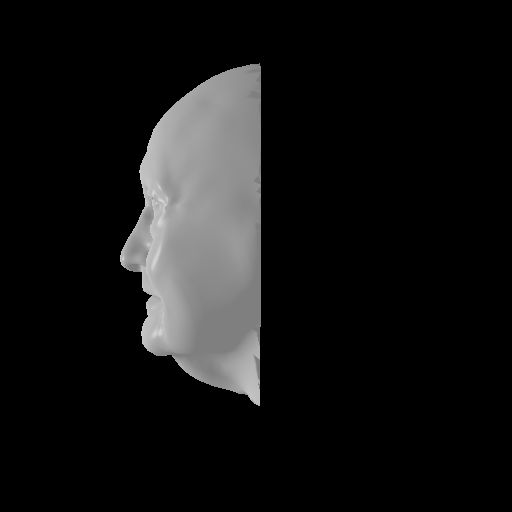

In [25]:
config.viewpoint_azimuth = +90#, 0.0, 0.0]

SR = MeshFaceRenderer(config)
device = torch.device('cuda')

file = './data/stan-lee-face.stl'
mesh  = flip_mesh(scale_mesh(file, offset=-0.20))
verts = torch.tensor(mesh.vertices, device=device).float()[None]
faces = torch.tensor(mesh.faces, device=device)[None]
#views_no = len(config.viewpoint_azimuth)

verts = GeoAugment(verts, config.geoaug_policy)
renders =  SR(verts, faces, device)
print(renders.shape)
img = ToPILImage()(renders[0])
img

torch.Size([1, 1, 512, 512])


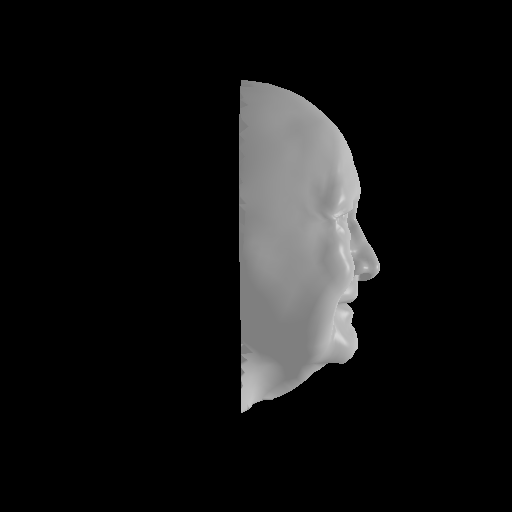

In [26]:
config.viewpoint_azimuth = -90#, 0.0, 0.0]

SR = MeshFaceRenderer(config)
device = torch.device('cuda')

file = './data/stan-lee-face.stl'
mesh  = flip_mesh(scale_mesh(file, offset=-0.20))
verts = torch.tensor(mesh.vertices, device=device).float()[None]
faces = torch.tensor(mesh.faces, device=device)[None]
#views_no = len(config.viewpoint_azimuth)

verts = GeoAugment(verts, config.geoaug_policy)
renders =  SR(verts, faces, device)
print(renders.shape)
img = ToPILImage()(renders[0])
img